In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
def grid(n, m, l):
    grid = [[i, j, k] for i in range(n) for j in range(m) for k in range(l)]
    grid = np.array(grid)
    grid = grid*2/ np.array([n, m, l]) - np.array([1, 1, 1])
    grid += np.array([1, 1, 1])/np.array([n, m, l])
    return grid

def PBC_distances(positions):
    N = positions.shape[0]
    result = np.array([positions]*positions.shape[0])
    result = result - result.transpose(1, 0, 2)
    result = (result + 1)%2 - 1
    return result

def PBC_forces(positions, eps, sigma):
    dist = PBC_distances(positions)
    d_norm = np.linalg.norm(dist, axis = 2)
    d_norm = np.where(d_norm == 0, np.inf, d_norm)
    F = 24*eps/(d_norm**2)*(2*(sigma/d_norm)**12 - (sigma/d_norm)**6)
    F = np.transpose(np.array([F]*3), axes = (1, 2, 0))
    F = -F*dist
    F = F.sum(axis = 1)
    return F

def U_LJ(positions, eps, sigma):
    dist = PBC_distances(positions)
    d_norm = np.linalg.norm(dist, axis = 2)
    d_norm = np.where(d_norm == 0, np.inf, d_norm)
    sixth_p = (sigma/d_norm)**6
    U = 4*eps*(sixth_p**2 - sixth_p)
    U_total = U.sum()
    return U_total

In [3]:
class system:
    def __init__(self, N, sigma = 0.05, eps = 0.05):
        self.N = N
        self.sigma = sigma
        self.eps = eps
        self.n = int(np.cbrt(N))
        self.positions = grid(self.n, self.n, self.n)
        self.N = self.n**3
        self.v = np.random.rand(self.N, 3)
        self.v -= self.v.mean(axis=0)
        self.v = self.v/self.v.std(axis=0)

        self.initial_positions = grid(self.n, self.n, self.n)

    def run(self, dt, steps):
        self.prev_positions, self.positions = self.positions, (self.positions + self.v*dt)
        KE, PE = np.zeros(steps), np.zeros(steps)
        p = np.zeros((steps, 3))
        i = 0
        v_log = np.zeros((steps, self.N, 3))
        MSD = np.zeros(steps)
        while i!= steps:
            forces = PBC_forces(self.positions, self.eps, self.sigma)
            new_positions = 2 * self.positions - self.prev_positions + forces * dt**2
            self.v = (new_positions - self.prev_positions) /(2 * dt)
            self.prev_positions, self.positions = self.positions, new_positions
            KE[i] = np.sum(self.v**2)
            PE[i] = U_LJ(self.positions, self.eps, self.sigma)
            v_log[i] = self.v
            p[i] = np.sum(self.v)
            MSD[i] = np.mean(np.power(np.linalg.norm(self.positions - self.initial_positions, axis = 1), 2))
            i += 1

        return self.positions, KE, PE, v_log, p, MSD

In [6]:
s = system(512)
dt = 0.001
positions, KE, PE, v_log, p, MSD = s.run(dt, 25000)

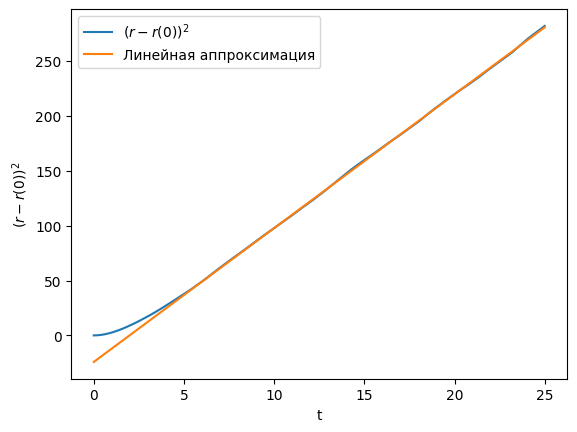

In [108]:
plt.plot(np.arange(25000)*dt, MSD, label = "$(r - r(0))^2$")
k, b = np.polyfit(np.arange(15000, 25000), MSD[15000:], 1)
plt.plot(np.arange(25000)*dt, k*np.arange(25000) + b, label = "Линейная аппроксимация")
plt.xlabel("t")
plt.ylabel("$(r - r(0))^2$")
plt.legend()

plt.savefig("mean_square_displacement.svg")

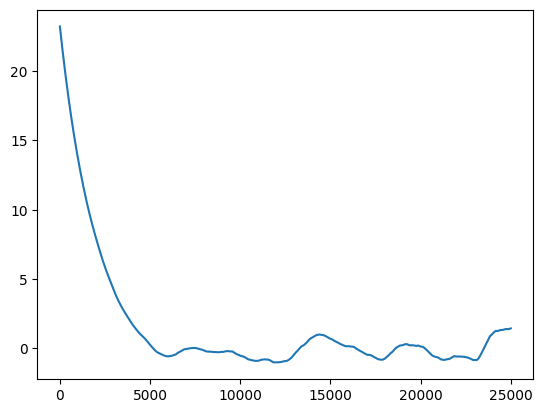

In [103]:
plt.plot(MSD - k*np.arange(25000) - b)

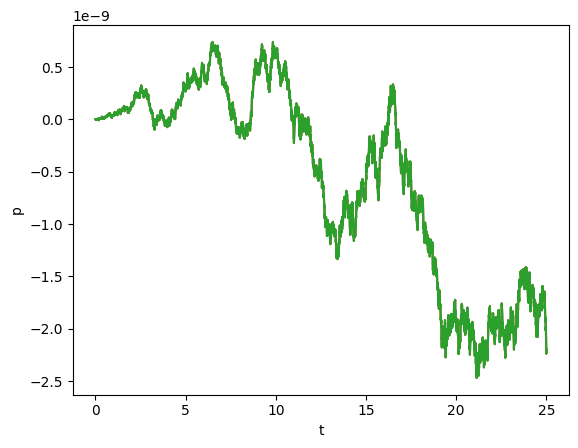

In [58]:
plt.plot(np.arange(0, 25, dt), p)
plt.xlabel("t")
plt.ylabel("p")
plt.savefig("momentum.svg")

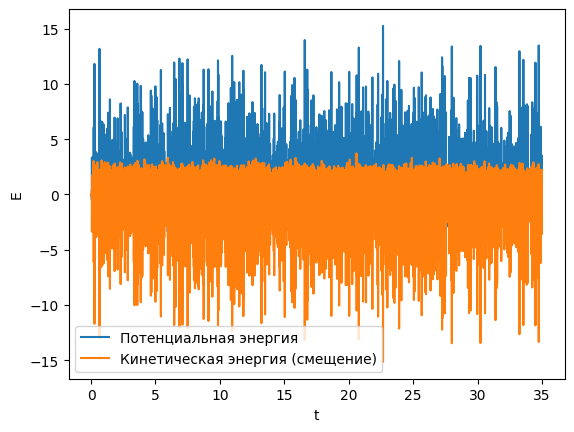

In [239]:
plt.plot(dt*np.arange(50000), PE, label = "Потенциальная энергия")
plt.plot(dt*np.arange(50000), KE - 3*s.N, label = "Кинетическая энергия (смещение)")
plt.xlabel("t")
plt.ylabel("E")
#plt.xlim(100, 200)
plt.legend()
plt.savefig("PE_KE.svg")

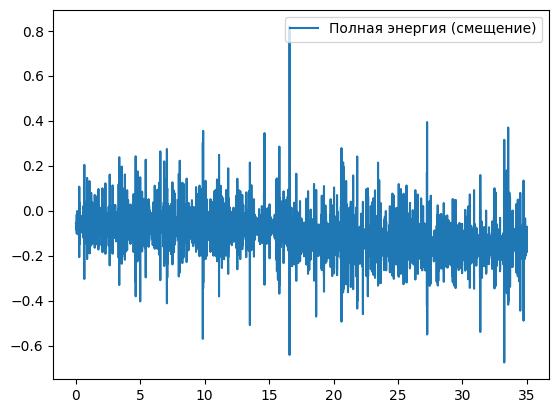

In [232]:
plt.plot(dt*np.arange(50000 - 1),KE[1:] + PE[:-1] - 3*s.N, label = "Полная энергия (смещение)")
plt.legend()
plt.savefig("Energy.svg")

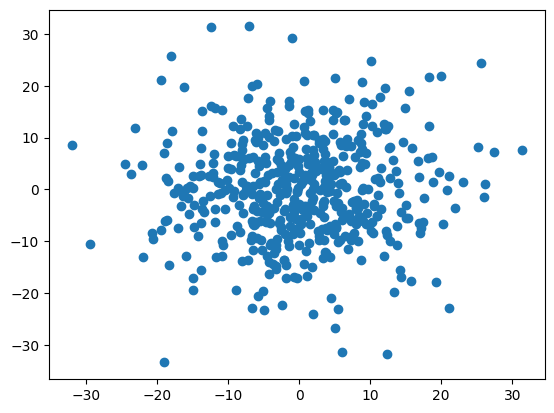

In [18]:
plt.scatter(s.positions[:, 0], s.positions[:, 1])

In [19]:
#kT/m = 1

def f(v):
    return (2*np.pi)**(-3/2)*4*np.pi*np.power(v, 2)*np.exp(-np.power(v, 2)/2)

(array([ 8., 16., 16., 56., 42., 66., 72., 50., 52., 41., 29., 15., 18.,
         8.,  8.,  6.,  4.,  1.,  1.,  3.]),
 array([0.13122131, 0.33421649, 0.53721167, 0.74020686, 0.94320204,
        1.14619722, 1.3491924 , 1.55218759, 1.75518277, 1.95817795,
        2.16117314, 2.36416832, 2.5671635 , 2.77015868, 2.97315387,
        3.17614905, 3.37914423, 3.58213942, 3.7851346 , 3.98812978,
        4.19112496]),
 <BarContainer object of 20 artists>)

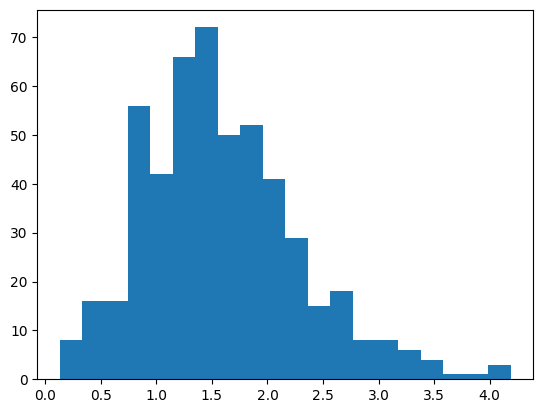

In [20]:
plt.hist(np.linalg.norm(s.v, axis = 1), bins = 20)

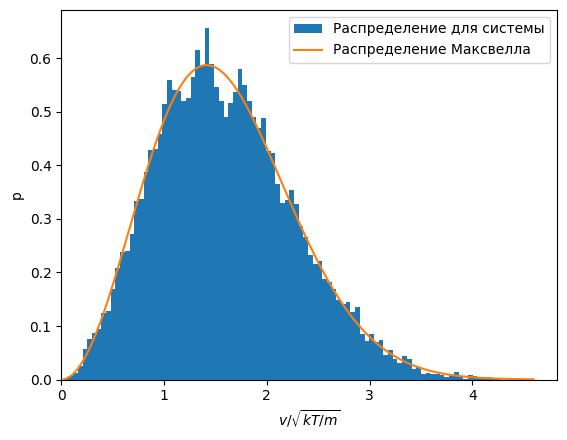

In [53]:
bins = 100
array = np.linalg.norm(v_log[1000:], axis = 2)
plt.hist(np.linalg.norm(v_log[1000:], axis = 2).flatten(), bins = bins, density=True, label="Распределение для системы")
plt.plot(np.arange(np.min(array), np.max(array), 0.01), f(np.arange(np.min(array), np.max(array), 0.01)), label="Распределение Максвелла")
plt.xlim(0)
#plt.ylim(0, 1000)
plt.xlabel("$ v/\\sqrt{kT/m} $")
plt.ylabel("p")
plt.legend()

plt.savefig("Distribution.svg")



In [71]:
PBC_forces(s.positions, s.eps, s.sigma), U_LJ(s.positions, s.eps, s.sigma)

(array([[ 1.13143313e-01, -8.20738174e-02, -3.16271701e-01],
        [ 7.51728612e-03,  1.30327003e-03,  1.70547774e-02],
        [-8.80195614e-03, -1.00563950e-02, -8.61581432e-03],
        ...,
        [-1.28117332e-03,  1.67055780e-03, -4.08880219e-04],
        [ 4.32058497e-03,  1.16075732e-03, -3.36039040e-03],
        [-2.53212732e-04,  1.53428180e-03,  1.60616019e-04]]),
 2.6271918387218935)

ValueError: x and y must have same first dimension, but have shapes (25000,) and (50000,)

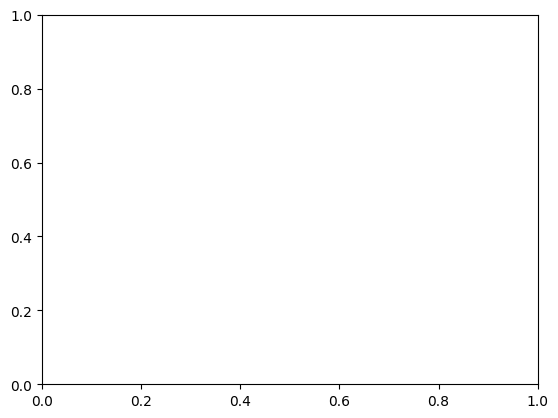

In [225]:
D_ES = (MSD - b)/(6*0.001*(np.arange(MSD.size) + 1))
plt.plot(dt*np.arange(25000), D_ES)
plt.ylim(2, 2.2)
plt.plot(dt*np.arange(25000), np.mean(D_ES[7500:])*np.ones(25000), 'r')
plt.xlabel("t")
plt.ylabel("D")
plt.savefig("D_ES.svg")

In [77]:
np.std(D_ES[7500:]), np.mean(D_ES[7500:])#, np.std(D_ES[12500:]), np.mean(D_ES[12500:])

(0.006427983973520022, 2.0324785978369673)

In [162]:
ACVF_0 = np.mean(np.multiply(v_log, v_log[0]), axis=(1, 2))
D_GK = np.sum(np.multiply(ACVF_0*0.001, np.exp(-np.arange(v_log.shape[0])/np.inf)))

In [163]:
D_GK

2.391078202265773

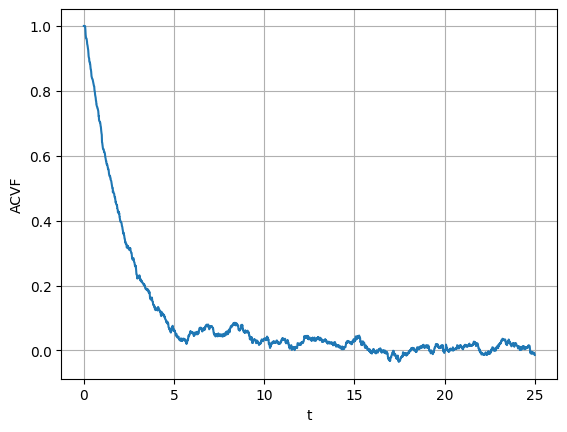

In [164]:
plt.plot(np.arange(0, 25, 0.001), ACVF_0)
plt.grid()
plt.xlabel("t")
plt.ylabel("ACVF")
plt.savefig("ACVF.svg")

In [197]:
D_t = np.zeros(200)
for i in range(200):
    ACVF = np.mean(np.multiply(v_log[50*i:], v_log[50*i]), axis=(1, 2))
    D_t[i] = np.sum(ACVF*np.exp(-np.arange(0, int(ACVF.size))/np.inf)*0.001)
D_GK = np.mean(D_t)
np.mean(D_t), np.std(D_t)

(2.0666273134582407, 0.10885057337521073)

In [193]:
i = 0
ACVF = np.mean(np.multiply(v_log[50*i:], v_log[50*i]), axis=(1, 2))
D_t[i] = np.sum(ACVF*np.exp(-np.arange(0, int(ACVF.size))/25000)*0.001)

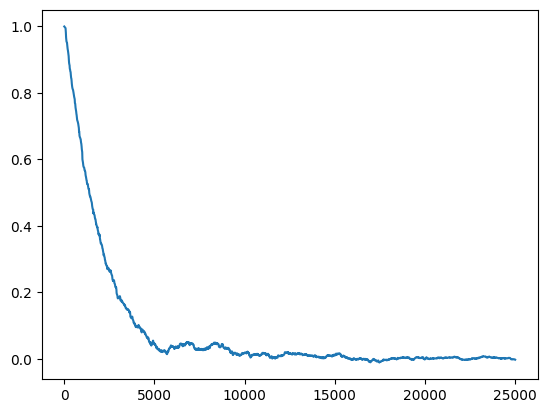

In [190]:
plt.plot(ACVF*np.exp(-np.arange(0, int(ACVF.size))/15000))

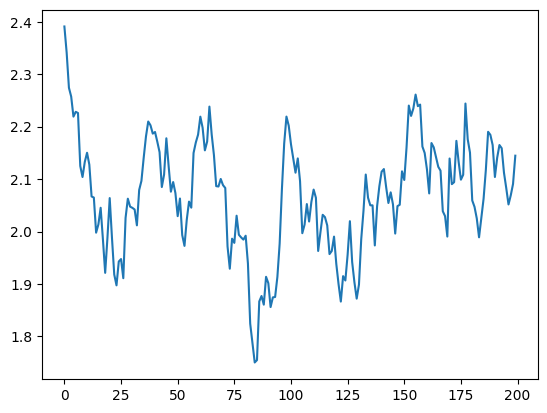

In [198]:
plt.plot(D_t)

In [172]:
D_GK

2.0666273134582407

In [138]:
np.sum(np.mean(np.multiply(v_log, v_log[0]), axis=(1, 2))*dt)

2.391078202265773

In [149]:
np.sum(np.mean(np.multiply(v_log[1000:], v_log[1000]), axis=(1, 2))*dt)

2.0638058402443336

In [203]:
s2 = system(512)
positions, KE, PE, v_log, p, MSD = s2.run(7e-4, 50000)

NameError: name 't' is not defined

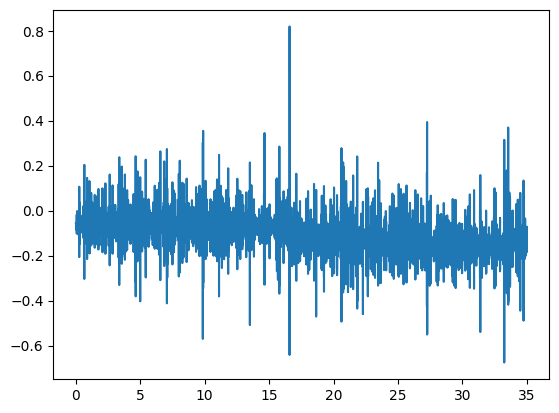

In [223]:
plt.plot(dt*np.arange(50000 - 1), KE[1:] + PE[:-1] - 3*512)
plt.xlabel(t)


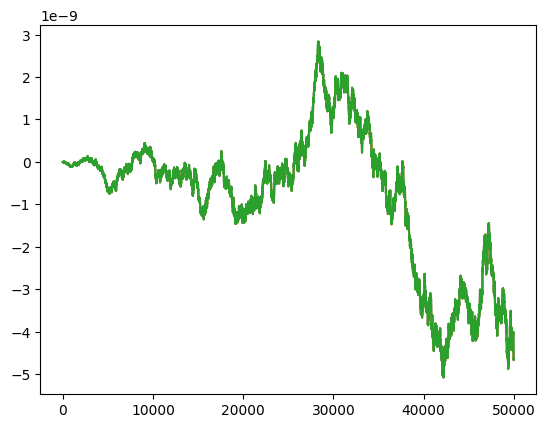

In [218]:
plt.plot(p)

In [212]:
dt = 7e-4

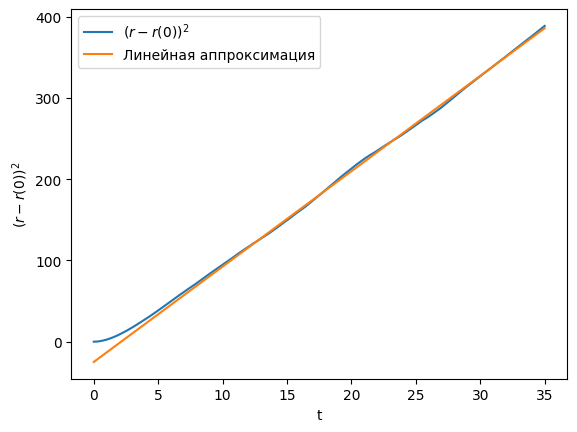

In [228]:
plt.plot(np.arange(50000)*dt, MSD, label = "$(r - r(0))^2$")
k, b = np.polyfit(np.arange(15000, 50000), MSD[15000:], 1)
plt.plot(np.arange(50000)*dt, k*np.arange(50000) + b, label = "Линейная аппроксимация")
plt.xlabel("t")
plt.ylabel("$(r - r(0))^2$")
plt.legend()

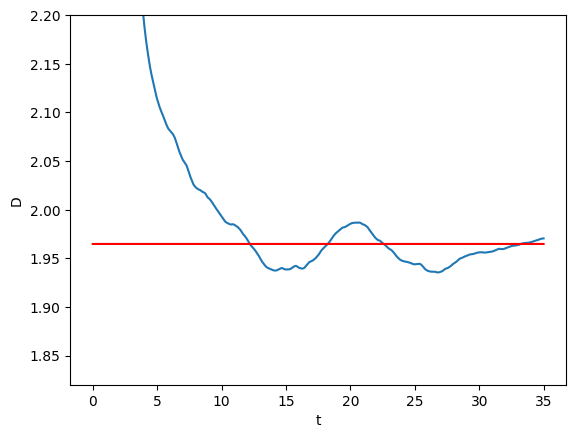

In [229]:
D_ES = (MSD - b)/(6*dt*(np.arange(MSD.size) + 1))
plt.plot(dt*np.arange(50000), D_ES)
plt.ylim(1.82, 2.2)
plt.plot(dt*np.arange(50000), np.mean(D_ES[10000:])*np.ones(50000), 'r')
plt.xlabel("t")
plt.ylabel("D")
plt.savefig("D_ES.svg")

In [230]:
np.mean(D_ES[10000:]), np.std(D_ES[10000:])

(1.9647317022652506, 0.02453664109140916)

In [244]:
np.mean(np.linalg.norm(s.v, axis=1)**2)/(2*s.eps)

30.09519972998986